# Image classification with classic techniques

Code developed by Marcelo Ferrer and Aymen Merchaoui

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60000 examples and a test set of 10000 examples. Both datasets are saved in a csv file where each line contains a label and the intensity values of a 28x28 grayscale image that depicts a piece of clothing. This dataset contains only objects of 10 classes.

In [2]:
import numpy as np
import csv
import cv2 as cv
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 

In [3]:
# Load a csv file of the fashion MNIST dataset
# - filename: path filename of the csv file
# Returns the list of images and the list of corresponding labels

def load_mnist_dataset(filename):
    f = open(filename, 'r')
    reader = csv.reader(f, delimiter=',')
    data = []
    images = []
    labels = []
    next(reader)
    for row in reader:
        labels.append(int(row[0]))
        images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
    f.close()
    return images, labels


In [4]:
train_images, train_labels = load_mnist_dataset("res/fashion-mnist_train.csv")
test_images, test_labels =  load_mnist_dataset("res/fashion-mnist_test.csv")

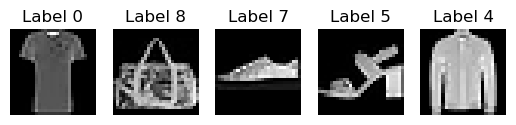

In [ ]:
n_samples = 5

f, ax = plt.subplots(1,n_samples)
for i in range(n_samples):
    idx = np.random.randint(0, high=len(train_images))
    ax[i].imshow(train_images[idx], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Label {train_labels[idx]}')
plt.show()

## Bag of words
The first approach will use the Bag of Words algorithm. This algorithm consists of the following steps:

1. Given a set of descriptors computed from the training images, define a vocabulary of visual words.
2. For each image in the training dataset
    1. Compute its descriptors
    2. Assign each descriptor to the closest word in the vocabulary
    3. Build a histogram of words
3. Use the histograms and the labels of each image in the training dataset to train a classifier 
4. Save both the vocabulary and trained classifier

### Step 1: Define a vocabulary of visual words

In [5]:
detector = cv.SIFT_create()

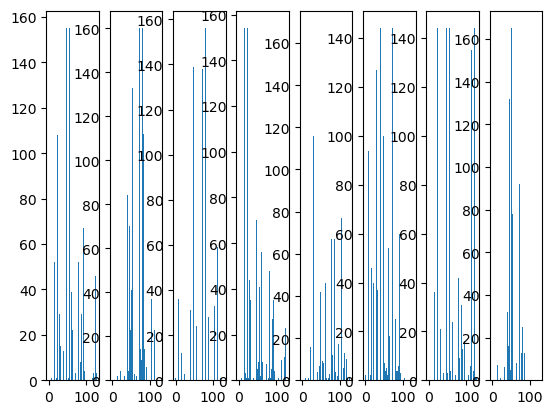

In [6]:
voc_size = 8 # Size of the vocabulary (toy example)

bow_trainer = cv.BOWKMeansTrainer(voc_size)

# Compute the descriptors of a image and add them to the bow trainer
image = train_images[0]
keypoints, descriptors = detector.detectAndCompute(image, np.ones(image.shape, dtype=np.uint8))
if descriptors is not None:
    bow_trainer.add(descriptors)

# Cluster the descriptors, this is, get the vocabulary
vocabulary = bow_trainer.cluster() 
f, ax = plt.subplots(1, voc_size)
for idx, word in enumerate(vocabulary):
    ax[idx].bar(range(0, word.shape[0]), word)
plt.show()

In [7]:
len(vocabulary)

8

Implement the vocabulary from the images in the training set.

In [8]:
# Show the list of labels
print("List of labels:", np.unique(train_labels))

List of labels: [0 1 2 3 4 5 6 7 8 9]


In [9]:
# Get a reduced dataset with a determinated number of items of each type
def get_reduced(train_images, train_labels, number_items):
    #print("Size of the train dataset:", len(train_labels))
    reduced_index = []

    for x in np.unique(train_labels):
        # For each label get the positions
        indexs = [i for i in range(len(train_labels)) if train_labels[i] == x]
        #print("Number of items in", x,"is:", len(indexs))

        # Get a determinated value of random elements of that list.
        # As each class has 6000 items, we take 1200 to have a 20% of each
        lst = random.choices(indexs, k=number_items)

        for y in lst:
            reduced_index.append(y)

    train_reduced_labels=new_list = [train_labels[i] for i in reduced_index]
    train_reduced_images=new_list = [train_images[i] for i in reduced_index]
    #print("Size of the train reduced dataset:",len(train_reduced_labels))

    for x in np.unique(train_reduced_labels):
        # For each label get the positions
        indexs = [i for i in range(len(train_reduced_labels)) if train_reduced_labels[i] == x]
        #print("Number of items in", x,"is:", len(indexs))

    return train_reduced_labels, train_reduced_images

In [10]:
# Get the vocabulary
def get_vocabulary(voc_size, images, labels, detector, output_filename):
    bow_trainer = cv.BOWKMeansTrainer(voc_size)

    train_reduced_labels, train_reduced_images = get_reduced(images, labels, 1200)
    
    for i in range(0,len(train_reduced_images)):
        image = train_reduced_images[i]
        keypoints, descriptors = detector.detectAndCompute(image, np.ones(image.shape, dtype=np.uint8))
        if descriptors is not None:
            bow_trainer.add(descriptors)
    
    vocabulary = bow_trainer.cluster()
    np.save(output_filename, vocabulary)
    return vocabulary   

Compute and save vocabularies of three suitable sizes

In [11]:
# vocabulary size 100 
v1 = get_vocabulary(100, train_images, train_labels, detector, "vocabulary_1")

In [12]:
# vocabulary size 200
v2 = get_vocabulary(200, train_images, train_labels, detector, "vocabulary_2")

In [13]:
# vocabulary size 500
v3 = get_vocabulary(500, train_images, train_labels, detector, "vocabulary_3")

### Step 2: Build histograms from the training dataset

In [14]:
matcher = cv.BFMatcher(cv.NORM_L2)
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)

In [15]:
bow_extractor.setVocabulary(vocabulary) # toy example

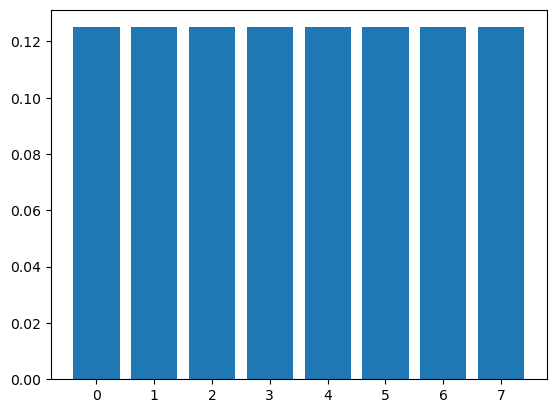

In [16]:
keypoints = detector.detect(train_images[0])
histograms = bow_extractor.compute(train_images[0], keypoints)
plt.bar(range(histograms[0].shape[0]), histograms[0])
plt.show()

In [17]:
histograms[0]

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
      dtype=float32)

Function that computes the histograms of a set of images  

In [18]:
#In case we didn't run the cells above to define the detector and the bow extractor we should run these:
#detector = cv.SIFT_create()
#matcher = cv.BFMatcher(cv.NORM_L2)
#bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)

# Get t he histograms
def get_histograms(bow_extractor, images, vocabulary):
    histograms = []
    ### Write your code here
    matcher = cv.BFMatcher(cv.NORM_L2)
    bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
    
    bow_extractor.setVocabulary(vocabulary)  
    for img in images:
        
        keypoints = detector.detect(img)
        histogram = bow_extractor.compute(img, keypoints)
        if histogram is None :
            histogram=np.zeros((1,len(vocabulary)))            
        else:
            histogram =  np.array(histogram)   
            #plt.bar(range(histogram[0].shape[0]), histogram[0])
            #plt.show() 
        histograms.append(histogram)

    return histograms   

In [19]:
#a function that takes a list of histograms and plot each histogram of specified photos
def plot_histogram(histograms,n):
    for i in range(0,n):
        plt.bar(range(histograms[i][0].shape[0]), histograms[i][0])
        plt.show()

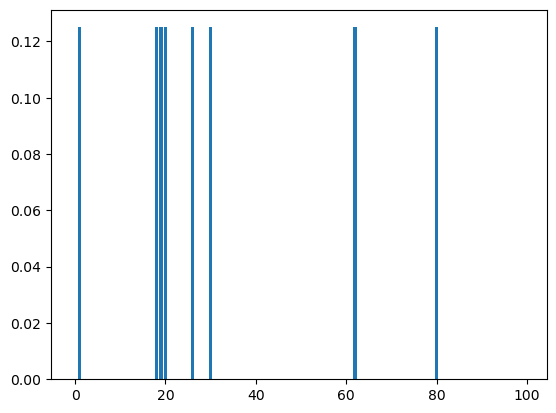

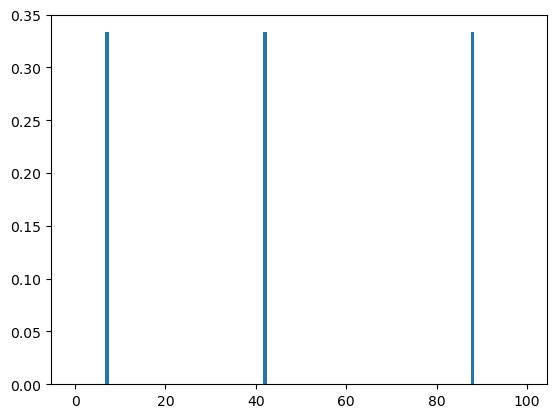

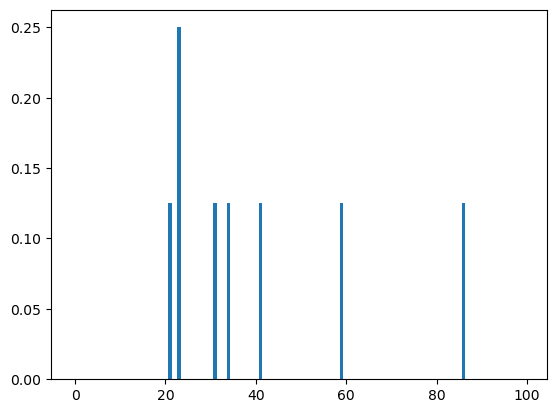

In [20]:
#get the histograms of the images for vocab_size = 100
h1 = get_histograms(bow_extractor, train_images, v1)

#plot the histograms of the first three photos
plot_histogram(h1,3)

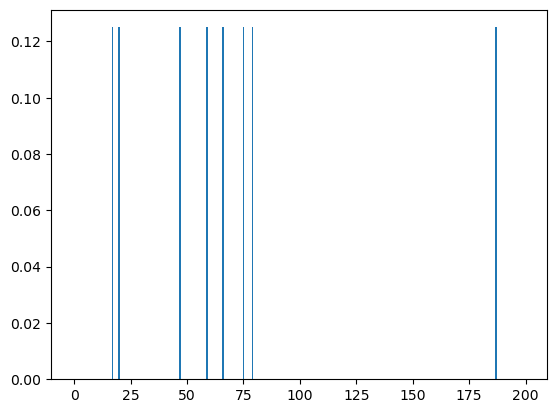

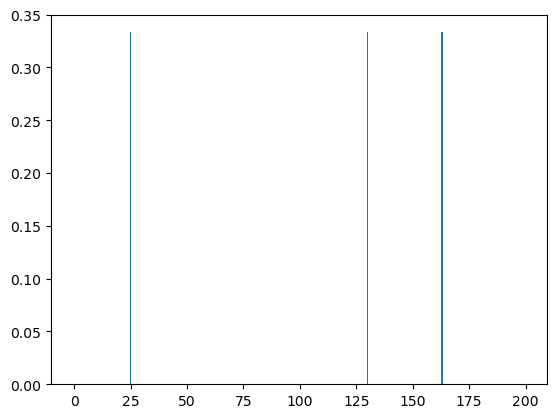

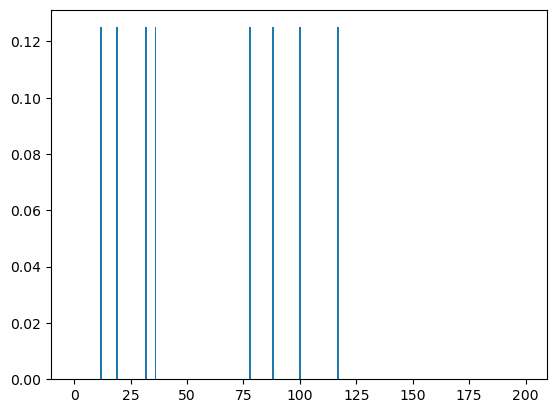

In [21]:
#get the histograms of the images for vocab_size = 200
h2 = get_histograms(bow_extractor, train_images, v2)

#plot the histograms of the first three photos
plot_histogram(h2,3)

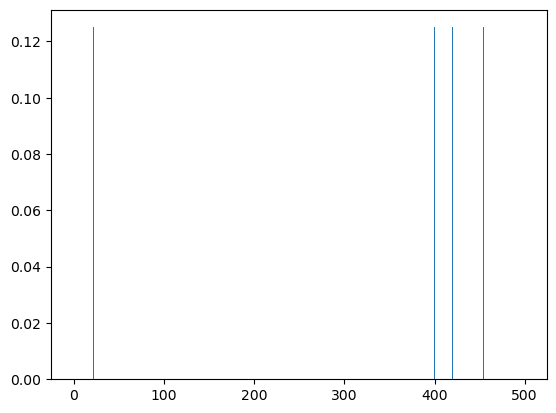

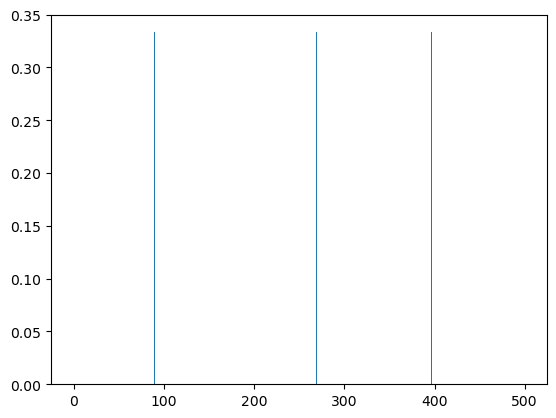

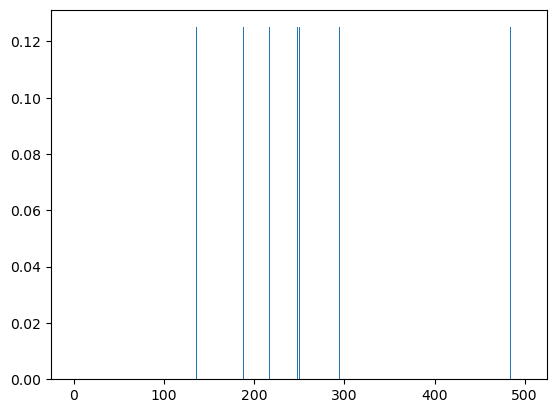

In [22]:
#get the histogram of the images of vocab_size = 500
h3 = get_histograms(bow_extractor, train_images, v3)

#plot the histograms of the first three photos
plot_histogram(h3,3)

### Step 3: Train a classifier

In [23]:
# h1, h2 and h3 are already generated using the bow_extractor.setVocabulary function
# when we called to the get_histograms before

#we should reshape the data to two dimension because the svm doesn't accept 3 dimensions
h1_reshaped = np.array(h1).reshape(len(h1), -1)
h2_reshaped = np.array(h2).reshape(len(h2), -1)
h3_reshaped = np.array(h3).reshape(len(h3), -1)

In [48]:
# Define the hyperparameters to tune
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
svc_parameters = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [1, 5, 10]}

In [24]:
def train_classifier(h_reshaped, classifier, parameters):
    #split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(h_reshaped, train_labels, test_size=0.2, random_state=42)

    # Create a grid search object
    model = GridSearchCV(classifier, parameters)

    #fit the data
    model.fit(x_train , y_train)

    #predict the test data in order to calculate the accuracy
    y_pred = model.best_estimator_.predict(x_test)

    #calculate the accuracy
    acc = accuracy_score(y_test,y_pred)
    print("Accuracy:",acc)

    #generate the confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    print("Confusion matrix: \n",conf_matrix)

    return model

In [26]:
# vocabulary size 100
model1 = train_classifier(h1_reshaped, SVC(), svc_parameters)

Accuracy: 0.58025
Confusion matrix: 
 [[710  90  38  74  44  58  95  14  86  23]
 [  2 951  14 127  10  25  13   7  25   0]
 [ 29  63 550  46 262  49 127  12  60   2]
 [124 196  93 538  60  47  40  49  87   8]
 [ 24  61 240  77 507  32 154  12  73   5]
 [ 16  64  21  30   5 845  16  92  16  36]
 [192 103 176  74 204  51 310  17 105  11]
 [ 29  59   8  33   3  81  10 829  17 155]
 [ 28  67  51  78  66  45  50  12 739  13]
 [ 23  18   3  23   5  33   7  83  31 984]]


In [29]:
# vocabulary size 200
model2 = train_classifier(h2_reshaped, SVC(), svc_parameters)

Accuracy: 0.6113333333333333
Confusion matrix: 
 [[ 724   88   45   96   30   50   97   13   80    9]
 [   5 1005   11   82    6   28   11    5   19    2]
 [  29   59  578   51  233   41  137    9   60    3]
 [ 112  247   81  533   70   37   46   39   72    5]
 [  26   56  223   78  538   16  185   13   49    1]
 [  16   56   10   13    5  906   13   85   10   27]
 [ 189   94  171   81  207   29  354    9   95   14]
 [  12   60    8   32    6   65   15  904   17  105]
 [  29   73   41   77   47   32   45   12  784    9]
 [  18   19    3   10    4   27    7   80   32 1010]]


In [31]:
# vocabulary size 500
model3 = train_classifier(h3_reshaped, SVC(), svc_parameters)

Accuracy: 0.6430833333333333
Confusion matrix: 
 [[ 772   89   37   93   27   42   90   10   67    5]
 [   8 1010    6   89    5   16    8    2   29    1]
 [  38   60  625   40  227   28  134    3   43    2]
 [ 123  197   74  606   64   27   55   37   58    1]
 [  20   51  179   67  621   12  168    9   58    0]
 [  12   47    3   15    4  927   13   77   20   23]
 [ 188   86  164   82  199   24  394   11   90    5]
 [  11   55    5   35    1   69   10  922   15  101]
 [  17   72   45   69   38   27   38   14  824    5]
 [   9   16    4   17    2   21    8   95   22 1016]]


In [51]:
# vocabulary size 500
model3rtf = train_classifier(h3_reshaped, RandomForestClassifier(), {'n_estimators': [10, 100, 200]})

Accuracy: 0.6180833333333333
Confusion matrix: 
 [[ 713   99   44   98   43   61   94   11   57   12]
 [   2 1025    8   70    9   16   11    6   24    3]
 [  29   60  611   37  231   44  127    7   50    4]
 [ 127  234   63  525   82   42   54   39   72    4]
 [  25   58  227   63  585   23  145    5   52    2]
 [  11   57    8   22    7  883    9   85   16   43]
 [ 190  102  192   76  219   44  316   13   78   13]
 [  14   62    6   22    6   59   12  912   10  121]
 [  22   73   58   73   38   32   29   11  803   10]
 [   7   21    1   10    4   22    7   69   25 1044]]


In [50]:
# vocabulary size 500
model3knn = train_classifier(h3_reshaped,KNeighborsClassifier(), {'n_neighbors': [10, 20, 100]})

Accuracy: 0.48433333333333334
Confusion matrix: 
 [[ 627  338   34   66   32   34   49    2   38   12]
 [  13 1042    5   63    8   13    8    3   16    3]
 [  50  308  473   38  175   21  104    3   26    2]
 [ 145  450   75  382   41   25   41   19   54   10]
 [  28  321  177   57  431   11  109    4   44    3]
 [  11  540    7    7    3  486    4   55   12   16]
 [ 168  431  139   50  162   20  215    6   44    8]
 [  16  240    5   23    6   48    4  774   11   97]
 [  20  407   42   36   24   26   36    9  536   13]
 [   7  251    0   12    2   16    6   45   25  846]]


In [25]:
# vocabulary size 500
model3gbc = train_classifier(h3_reshaped,GradientBoostingClassifier(), {'n_estimators': [10, 100, 200]})

Accuracy: 0.6209166666666667
Confusion matrix: 
 [[ 716  108   39  108   34   43  108    9   58    9]
 [   0 1009   13   99   11   16   10    2   13    1]
 [  22   88  579   41  232   32  163    4   38    1]
 [ 109  236   75  547   60   28   84   40   61    2]
 [  17   66  223   56  583   16  175    7   41    1]
 [   6   64    2   13    5  904   12   99   15   21]
 [ 178  114  159   88  194   33  392    6   72    7]
 [  11   70    9   25    8   84    9  891   15  102]
 [  12   87   42   77   39   29   34   11  809    9]
 [  11   31    3   16    6   14    8   75   25 1021]]


### Step 4: Test the classifier

In [26]:
#get the histogram of the images of vocab_size = 100
ht1 = get_histograms(bow_extractor, test_images, v1)
ht1_reshaped = np.array(ht1).reshape(len(ht1), -1)

#get the histogram of the images of vocab_size = 200
ht2 = get_histograms(bow_extractor, test_images, v2)
ht2_reshaped = np.array(ht2).reshape(len(ht2), -1)

#get the histogram of the images of vocab_size = 500
ht3 = get_histograms(bow_extractor, test_images, v3)
ht3_reshaped = np.array(ht3).reshape(len(ht3), -1)

In [28]:
#predict the test data in order to calculate the accuracy
y_pred = model1.best_estimator_.predict(ht1_reshaped)

#calculate the accuracy
acc = accuracy_score(test_labels,y_pred)
print("Accuracy:",acc)

#generate the confusion matrix
conf_matrix = confusion_matrix(test_labels,y_pred)
print("Confusion matrix: \n",conf_matrix)

Accuracy: 0.5789
Confusion matrix: 
 [[575  71  28  92  34  32  75  15  67  11]
 [  3 827  17 100   7  19   8   4  15   0]
 [ 27  62 431  42 215  37 116   5  61   4]
 [ 89 169  62 440  46  45  40  37  65   7]
 [ 16  38 217  51 470  25 126   8  46   3]
 [ 17  58  18  21   8 734  22  72  12  38]
 [166  93 144  66 173  35 219  21  79   4]
 [ 26  63   6  48   7  60   7 634  18 131]
 [ 33  41  50  61  56  37  44  12 660   6]
 [ 21  15  10  18   2  28  15  70  22 799]]


In [30]:
#predict the test data in order to calculate the accuracy
y_pred = model2.best_estimator_.predict(ht2_reshaped)

#calculate the accuracy
acc = accuracy_score(test_labels,y_pred)
print("Accuracy:",acc)

#generate the confusion matrix
conf_matrix = confusion_matrix(test_labels,y_pred)
print("Confusion matrix: \n",conf_matrix)

Accuracy: 0.6133
Confusion matrix: 
 [[585  72  38  86  30  31  80  16  54   8]
 [  1 873  11  62  11  20   5   7  10   0]
 [ 32  66 441  32 224  27 111   4  60   3]
 [ 89 184  57 449  57  26  37  26  60  15]
 [ 24  45 163  52 490  13 164   6  41   2]
 [ 15  48  11  20   3 772  14  73  18  26]
 [150  98 124  80 137  27 310   6  62   6]
 [ 13  60   4  36   8  41  12 695  18 113]
 [ 25  41  38  64  41  36  40  11 697   7]
 [ 16  14   8  14   1  20  10  72  24 821]]


In [34]:
#predict the test data in order to calculate the accuracy
y_pred = model3.best_estimator_.predict(ht3_reshaped)

#calculate the accuracy
acc = accuracy_score(test_labels,y_pred)
print("Accuracy:", acc)

#generate the confusion matrix
conf_matrix = confusion_matrix(test_labels,y_pred)
print("Confusion matrix: \n",conf_matrix)

Accuracy: 0.6429
Confusion matrix: 
 [[607  67  27  90  29  24  90   7  51   8]
 [  5 886   6  68   4  12   5   2  11   1]
 [ 24  60 498  35 200  19 104   5  54   1]
 [ 92 154  44 506  51  29  43  25  51   5]
 [ 14  42 162  43 533   9 161   2  34   0]
 [ 12  43   6  16   0 807  10  80  11  15]
 [159  93 111  75 139  20 328   8  62   5]
 [  8  60   1  34   5  53  10 710  16 103]
 [ 22  44  42  49  43  24  37  12 719   8]
 [  9  15  10  14   2  18   7  64  26 835]]


In [54]:
#predict the test data in order to calculate the accuracy
y_pred = model3rtf.best_estimator_.predict(ht3_reshaped)

#calculate the accuracy
acc = accuracy_score(test_labels,y_pred)
print("Accuracy:", acc)

#generate the confusion matrix
conf_matrix = confusion_matrix(test_labels,y_pred)
print("Confusion matrix: \n",conf_matrix)

Accuracy: 0.6131
Confusion matrix: 
 [[577  77  37  97  31  31  70  19  55   6]
 [  3 878   8  63   8  18   3   3  15   1]
 [ 22  67 445  45 224  40  97   5  52   3]
 [102 182  35 460  63  37  46  24  40  11]
 [ 22  44 204  42 497  15 129   5  38   4]
 [ 13  46   6  23   0 767   5  89   7  44]
 [143  98 129  81 164  36 266  13  61   9]
 [ 14  56   9  24   7  51  13 692  10 124]
 [ 18  49  34  59  40  41  29  14 707   9]
 [ 12  15   4  13   3  23   6  66  16 842]]


In [55]:
#predict the test data in order to calculate the accuracy
y_pred = model3knn.best_estimator_.predict(ht3_reshaped)

#calculate the accuracy
acc = accuracy_score(test_labels,y_pred)
print("Accuracy:", acc)

#generate the confusion matrix
conf_matrix = confusion_matrix(test_labels,y_pred)
print("Confusion matrix: \n",conf_matrix)

Accuracy: 0.4811
Confusion matrix: 
 [[513 260  28  53  26  16  46  10  38  10]
 [ 14 885   5  61   8   9   3   3  11   1]
 [ 36 281 366  29 165  14  76   4  27   2]
 [104 351  44 343  40  18  33  18  40   9]
 [ 22 273 159  35 378   8  99   1  24   1]
 [ 10 467   4  15   3 423   7  50  10  11]
 [126 345 130  41 113  18 178   8  35   6]
 [ 12 230   2  23   9  33   4 573  10 104]
 [ 19 351  40  39  22  15  26   9 466  13]
 [ 11 196   4  14   3  14   3  49  20 686]]


In [27]:
#predict the test data in order to calculate the accuracy
y_pred = model3gbc.best_estimator_.predict(ht3_reshaped)

#calculate the accuracy
acc = accuracy_score(test_labels,y_pred)
print("Accuracy:", acc)

#generate the confusion matrix
conf_matrix = confusion_matrix(test_labels,y_pred)
print("Confusion matrix: \n",conf_matrix)

Accuracy: 0.6159
Confusion matrix: 
 [[587  87  31  99  23  24  79  10  55   5]
 [  4 878   5  75   8   9   5   4  10   2]
 [ 16  69 461  34 222  29 121   6  40   2]
 [ 85 197  60 474  40  22  51  26  41   4]
 [ 12  50 192  55 497  10 148   3  30   3]
 [  8  60   6  29   1 757  12  85  11  31]
 [149 113 103  93 150  37 285  11  55   4]
 [  6  68   6  29   4  55  12 692  17 111]
 [ 21  56  42  52  30  26  46  13 707   7]
 [  6  22   6  23   3  14  13  63  29 821]]
